In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import colorcet as cc
import matplotlib.pyplot as plt
from geopy.distance import distance

In [2]:
# load data
df = pd.read_csv('merge.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18451 entries, 0 to 18450
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Year                                 18451 non-null  int64  
 1   Quarter                              18451 non-null  int64  
 2   Total_Mkt_Fare                       18451 non-null  float64
 3   depart_city                          18451 non-null  int64  
 4   arrival_city                         18451 non-null  int64  
 5   airlineID                            18451 non-null  int64  
 6   Passengers_by_Carrier                18451 non-null  int64  
 7   CarriersMktShare                     18451 non-null  float64
 8   CarrierAvgFare                       18451 non-null  float64
 9   Carrier_MinFareIncrement             18451 non-null  int64  
 10  CarrierMinPassangerShare             18451 non-null  float64
 11  CarrierMaxFareIncrement     

In [3]:
from sklearn.model_selection import train_test_split

X = df.loc[:, df.columns != 'Total_Mkt_Fare']
y = df.Total_Mkt_Fare

# make 30% test set and 70% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)
# devide test into half to form validation set: 15% test, 15% valid, 70% train
X_hold, X_valid, y_hold, y_valid = train_test_split(X_test, y_test, test_size=0.5, 
                                                    random_state=21)

In [4]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_hold.shape, y_hold.shape

((12915, 23), (12915,), (2768, 23), (2768,), (2768, 23), (2768,))

In [5]:
# cross validation (k-fold)
from sklearn.model_selection import cross_val_score

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

((12915, 23), (12915,), (5536, 23), (5536,))

In [7]:
# functions to calculate error
def RMSE(y, ypred):
    differences = [(x-y)**2 for x, y in zip(ypred, y)]
    
    return np.sqrt(sum(differences) / len(differences))

def MAE(y, ypred):
    return abs(y-ypred).mean()

# Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression

clf = LinearRegression()
reg = clf.fit(X_train, y_train)

reg.score(X_valid, y_valid)

0.9444002066702909

In [9]:
reg.score(X_test, y_test)

0.9416343176794186

In [10]:
preds = reg.predict(X_valid)
rmse = RMSE(y_valid, preds)
mae = MAE(y_valid, preds)
print('Linear Regression validation RMSE: {}, MAE: {}'.format(rmse, mae))

Linear Regression validation RMSE: 21.027457152907314, MAE: 13.506599926747224


In [11]:
preds = reg.predict(X_hold)
rmse = RMSE(y_hold, preds)
mae = MAE(y_hold, preds)
print('Linear Regression test RMSE: {}, MAE: {}'.format(rmse, mae))

Linear Regression test RMSE: 21.746788451920022, MAE: 13.764747402312471


In [12]:
reg_scores = cross_val_score(reg, Xtrain, ytrain, cv=10)
print('CV scores of linear regression model for each fold: \n', reg_scores, 
      '\nMean of CV scores: ', np.mean(reg_scores))

CV scores of linear regression model for each fold: 
 [0.94353287 0.93262557 0.94574349 0.94252259 0.94761106 0.94638666
 0.94174457 0.94503373 0.94826514 0.94375992] 
Mean of CV scores:  0.9437225593052248


In [13]:
# r-2 score of linear regression model
from sklearn.metrics import r2_score

preds = reg.predict(Xtest)
reg_r2 = r2_score(ytest, preds)
print('R^2 score of linear regression model for test CV: ', reg_r2)

R^2 score of linear regression model for test CV:  0.9429348736422177


# KNN, Bagging Regressor and GridSearchCV

Use GridSearchCV to find the best kNN hyperparameters and push kNN to its maximum performance using bagging.

In [14]:
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

KNeighborsRegressor()

In [15]:
knn_model.score(X_valid, y_valid)

0.6888446632564005

#### Note: In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.  On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.

In [16]:
preds = knn_model.predict(X_valid)
rmse = RMSE(y_valid, preds)
mae = MAE(y_valid, preds)
print('KNN validation RMSE: {}, MAE: {}'.format(rmse, mae))

KNN validation RMSE: 49.743781279048925, MAE: 31.130755057803466


Compare predicted results with y_test (hue) by looking at 'Year' and 'Quarter' plot

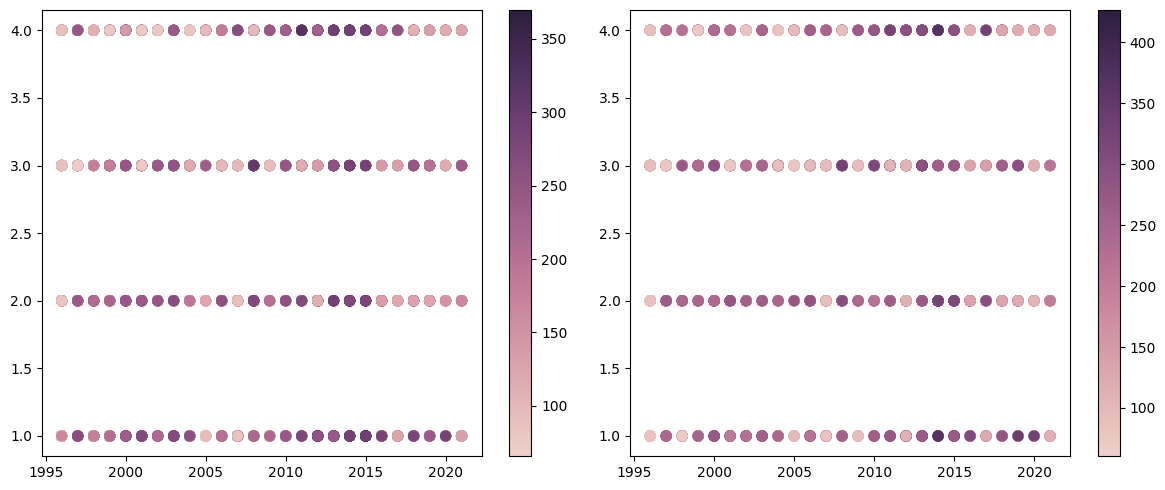

In [17]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
points1 = ax[0].scatter(X_valid.Year, X_valid.Quarter, c=preds, s=50, cmap=cmap)
points2 = ax[1].scatter(X_valid.Year, X_valid.Quarter, c=y_valid, s=50, cmap=cmap)
f.colorbar(points1)
f.colorbar(points2)
f.tight_layout()
plt.show()

Get best parameter 'n_neighbors' for KNN Regressor using Grid Search

### Hypertuning/Parameters

In [18]:
from sklearn.model_selection import GridSearchCV

parameters = {"n_neighbors": range(1, 50)}
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50)})

#### Note: In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.  On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.

In [19]:
gridsearch.best_params_

{'n_neighbors': 5}

In [20]:
# train_preds_grid = gridsearch.predict(X_train)
# rmse = RMSE(y_train, train_preds_grid)
# mae = MAE(y_train, train_preds_grid)
# print('GridSearchCV for k RMSE: {}, MAE: {}'.format(rmse, mae))

valid_preds_grid = gridsearch.predict(X_valid)
rmse = RMSE(y_valid, valid_preds_grid)
mae = MAE(y_valid, valid_preds_grid)
print('GridSearchCV for KNN Regressor with {} \nValidation RMSE: {}, MAE: {}'.format(
    gridsearch.best_params_, rmse, mae))

GridSearchCV for KNN Regressor with {'n_neighbors': 5} 
Validation RMSE: 49.743781279048925, MAE: 31.130755057803466


Get best parameter 'n_neighbors' and 'weights' for KNN Regressor using Grid Search

In [21]:
parameters = {
    "n_neighbors": range(1, 50),
    "weights": ["uniform", "distance"],
}
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50),
                         'weights': ['uniform', 'distance']})

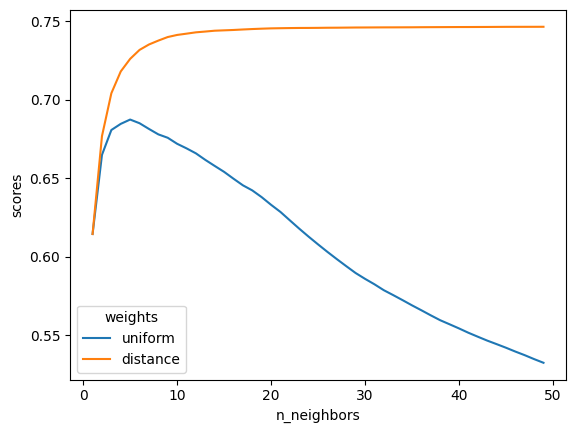

In [22]:
gs_scores = gridsearch.cv_results_['mean_test_score']
uniform = [i for index, i in enumerate(gs_scores) if index % 2 == 0]
distance = [i for index, i in enumerate(gs_scores) if index % 2 == 1]

x1 = range(1, 50)
x2 = range(1, 50)

plt.plot(x1, uniform)
plt.plot(x2, distance)
plt.xlabel('n_neighbors')
plt.ylabel('scores')
plt.legend(['uniform', 'distance'], title='weights')

plt.show()

#### Note: In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.  On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.

In [23]:
gridsearch.best_params_

{'n_neighbors': 49, 'weights': 'distance'}

In [24]:
test_preds_grid = gridsearch.predict(X_valid)
rmse = RMSE(y_valid, test_preds_grid)
mae = MAE(y_valid, test_preds_grid)
print('GridSearchCV for KNN Regressor with {} \nValidation RMSE: {}, MAE: {}'.format(
    gridsearch.best_params_, rmse, mae))

GridSearchCV for KNN Regressor with {'n_neighbors': 49, 'weights': 'distance'} 
Validation RMSE: 43.74303548754359, MAE: 23.17344355936333


Apply best parameter 'n_neighbors' and 'weights' for KNN Regressor to Bagging Regressor to get best performance.

### Cross-Validation Mean and R^2 of KNN Bagging

In [25]:
best_k = gridsearch.best_params_["n_neighbors"]
best_weights = gridsearch.best_params_["weights"]
bagged_knn = KNeighborsRegressor(n_neighbors=best_k, weights=best_weights)

In [26]:
from sklearn.ensemble import BaggingRegressor

bagging_model = BaggingRegressor(bagged_knn, n_estimators=100)
bagging_model.fit(X_train, y_train)
test_preds_grid = bagging_model.predict(X_test)
rmse = RMSE(y_test, test_preds_grid)
mae = MAE(y_test, test_preds_grid)
print('Bagging Regressor test RMSE: {}, MAE: {}'.format(rmse, mae))

Bagging Regressor test RMSE: 43.84833152933919, MAE: 25.07828970698652


In [27]:
# Overall bagging KNN regressor validation accuracy:
bagging_model.score(X_valid, y_valid)

0.7558633892787447

In [28]:
# Overall bagging KNN regressor accuracy on test set:
bagging_model.score(X_hold, y_hold)

0.753282484575015

In [29]:
# cross validation (k-fold)
bag_scores = cross_val_score(bagging_model, Xtrain, ytrain, cv=10)
print('CV scores of KNN bagging model for each fold: \n', bag_scores, 
      '\nMean of CV scores: ', np.mean(bag_scores))

CV scores of KNN bagging model for each fold: 
 [0.77084728 0.75674535 0.74936349 0.72718187 0.76017911 0.75384783
 0.76990507 0.73604674 0.75245416 0.75104352] 
Mean of CV scores:  0.7527614416936342


In [30]:
# r^2 score of bagging KNN model
preds = bagging_model.predict(Xtest)
bag_r2 = r2_score(ytest, preds)
print('R^2 score of KNN bagging model for test CV: ', bag_r2)

R^2 score of KNN bagging model for test CV:  0.904297607035919


# Gradient Boosting

In [31]:
pip install scikit-optimize

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV

In [33]:
# Step 2: Train the Gradient Boosting Model
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

# Step 3: Validate the Model
val_preds = gb_model.predict(X_valid)
val_rmse = RMSE(y_valid, val_preds)
val_mae = MAE(y_valid, val_preds)
print("Gradient Boosting Validation RMSE:", val_rmse)
print("Gradient Boosting Validation MAE:", val_mae)

Gradient Boosting Validation RMSE: 15.022303112431135
Gradient Boosting Validation MAE: 9.345724509219487


### Hypertuning/Parameters

In [34]:
# Define the parameter grid
param_dist = {
    'n_estimators': (50, 200),
    'learning_rate': (0.01, 0.5, 'log-uniform'),
    'max_depth': (3, 7),
}

# Perform hyperparameter tuning with BayesSearchCV
bayes_search = BayesSearchCV(estimator=GradientBoostingRegressor(), search_spaces=param_dist, 
                             n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42)
bayes_search.fit(X_train, y_train)

# Get the best model
best_model_bayes = bayes_search.best_estimator_

# Print the best hyperparameters found
print("Best Hyperparameters (Bayesian Optimization):", bayes_search.best_params_)

# Evaluate on Test Set
test_preds_bayes = best_model_bayes.predict(X_hold)
test_rmse_bayes = RMSE(y_hold, test_preds_bayes)
test_mae_bayes = MAE(y_hold, test_preds_bayes)
print("Test RMSE (Bayesian Optimization):", test_rmse_bayes)
print("Test MAE (Bayesian Optimization):", test_mae_bayes)

Best Hyperparameters (Bayesian Optimization): OrderedDict([('learning_rate', 0.0837964291511578), ('max_depth', 7), ('n_estimators', 124)])
Test RMSE (Bayesian Optimization): 12.30658159405196
Test MAE (Bayesian Optimization): 6.1941115372009286


### Test results - Plotted Accuracies

In [35]:
import matplotlib.pyplot as plt
import numpy as np

Validation RMSE (Bayesian Optimization): 10.660137095737406
Validation MAE (Bayesian Optimization): 5.9647906287508325


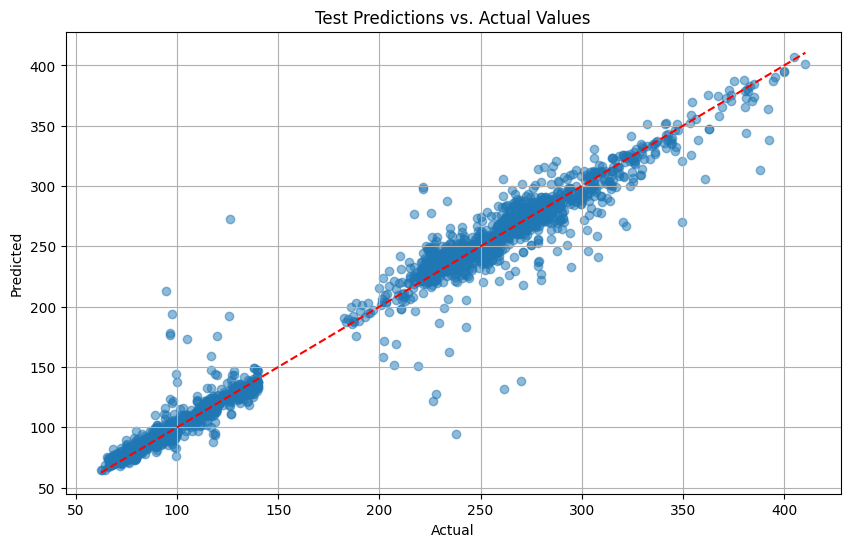

Test RMSE (Bayesian Optimization): 12.30658159405196
Test MAE (Bayesian Optimization): 6.1941115372009286


In [36]:
# Compute accuracy on the validation set
val_preds_bayes = best_model_bayes.predict(X_valid)
val_rmse_bayes = RMSE(y_valid, val_preds_bayes)
val_mae_bayes = MAE(y_valid, val_preds_bayes)
print("Validation RMSE (Bayesian Optimization):", val_rmse_bayes)
print("Validation MAE (Bayesian Optimization):", val_mae_bayes)

# Plot test predictions against actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_hold, test_preds_bayes, alpha=0.5)
plt.plot([min(y_hold), max(y_hold)], [min(y_hold), max(y_hold)], linestyle='--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Test Predictions vs. Actual Values')
plt.grid(True)
plt.show()

# Print test RMSE and MAE
print("Test RMSE (Bayesian Optimization):", test_rmse_bayes)
print("Test MAE (Bayesian Optimization):", test_mae_bayes)

### Cross-Validation Mean and R^2 of Bayesian Optimization

In [37]:
# cross validation (k-fold)
bay_scores = cross_val_score(best_model_bayes, Xtrain, ytrain, cv=10)
print('CV scores of KNN bagging model for each fold: \n', bay_scores, 
      '\nMean of CV scores: ', np.mean(bay_scores))

CV scores of KNN bagging model for each fold: 
 [0.98030038 0.97328859 0.98220931 0.98306143 0.98324283 0.98390502
 0.98070001 0.98194685 0.98617451 0.98269627] 
Mean of CV scores:  0.9817525198995245


In [38]:
# r^2 score of Gradient Boosting Bayesian Optimization model
preds = best_model_bayes.predict(Xtest)
bay_r2 = r2_score(ytest, preds)
print('R^2 score of Bayesian Optimized Gradient Boosting model for test CV: ', bay_r2)

R^2 score of Bayesian Optimized Gradient Boosting model for test CV:  0.9924648062252803


# Random Forest

### Random Forest on Validation Set

In [39]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Instantiate the imputer with a strategy (e.g., mean, median, or constant)
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on the training data
X_train_imputed = imputer.fit_transform(X_train)
X_valid_imputed = imputer.transform(X_valid)

# Instantiate the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the imputed training data
rf_model.fit(X_train_imputed, y_train)

# Predictions on the imputed validation set
rf_preds_valid = rf_model.predict(X_valid_imputed)

# Evaluate the model on the validation set
rmse_valid = np.sqrt(mean_squared_error(y_valid, rf_preds_valid))
mae_valid = mean_absolute_error(y_valid, rf_preds_valid)

print(f'Random Forest Validation RMSE: {rmse_valid}, MAE: {mae_valid}')

Random Forest Validation RMSE: 11.581506134077006, MAE: 5.85426170520231


### Random Forest on Test Set

In [41]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Instantiate the imputer with a strategy (e.g., mean, median, or constant)
imputer = SimpleImputer(strategy='mean')

# Predictions on the imputed test set
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_hold)
rf_preds_test = rf_model.predict(X_test_imputed)

# Evaluate the model on the test set
rmse_test = np.sqrt(mean_squared_error(y_hold, rf_preds_test))
mae_test = mean_absolute_error(y_hold, rf_preds_test)

print(f'Random Forest Test RMSE: {rmse_test}, MAE: {mae_test}')

Random Forest Test RMSE: 13.053516525247643, MAE: 5.985919147398844


### Calculating the R^2 for the Random Forest Model

In [43]:
# Fit and transform the imputer on the training and testing data
X_train_imputed = imputer.fit_transform(Xtrain)
X_test_imputed = imputer.transform(Xtest)

# Predictions on the imputed test set
rf_preds_test = rf_model.predict(X_test_imputed)

# Calculating R² on the validation set
rf_r2 = r2_score(ytest, rf_preds_test)

print(f'Random Forest Validation R²: {rf_r2}')

Random Forest Validation R²: 0.9923463729465447


### Calculating Random forest Cross-Validation Mean R^2

In [44]:
# Use cross_val_score to perform cross-validation
# rf_model is the RandomForestRegressor instance
# X_train_imputed is the imputed training data
# y_train is the training labels
# cv is the number of folds for cross-validation

# Replacing rf_model, X_train_imputed, y_train, and cv with the actual model and data
rf_scores = cross_val_score(rf_model, X_train_imputed, ytrain, cv=10)

# Calculating the mean R² across cross-validation folds
mean_r2_cv = np.mean(rf_scores)

print('CV scores of Random Forest model for each fold: \n', rf_scores, 
      '\nMean of CV scores: ', mean_r2_cv)

CV scores of Random Forest model for each fold: 
 [0.97689969 0.97341749 0.98169954 0.98095893 0.98179975 0.9821285
 0.97951272 0.97940085 0.98167595 0.98045118] 
Mean of CV scores:  0.9797944602575951


# Overall Cross-Validation Scores and R^2 Distribution

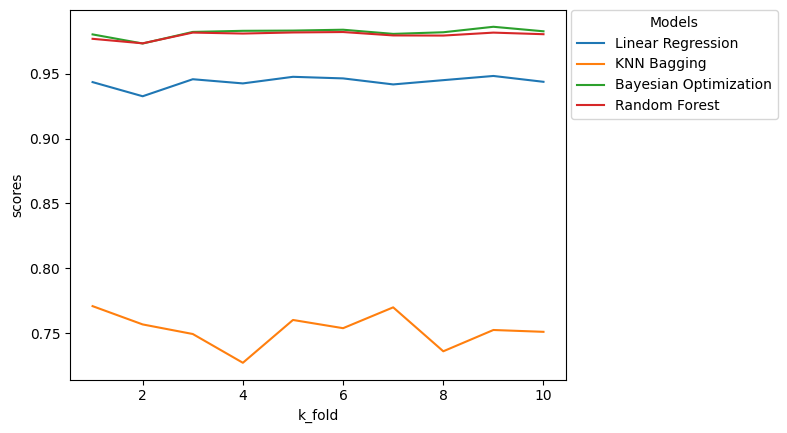

In [61]:
models = ['Linear Regression', 'KNN Bagging', 'Bayesian Optimization', 'Random Forest']
x = range(1, 11)

plt.plot(x, reg_scores)
plt.plot(x, bag_scores)
plt.plot(x, bay_scores)
plt.plot(x, rf_scores)
plt.xlabel('k_fold')
plt.ylabel('scores')
plt.legend(models, title='Models', 
          bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

plt.show()

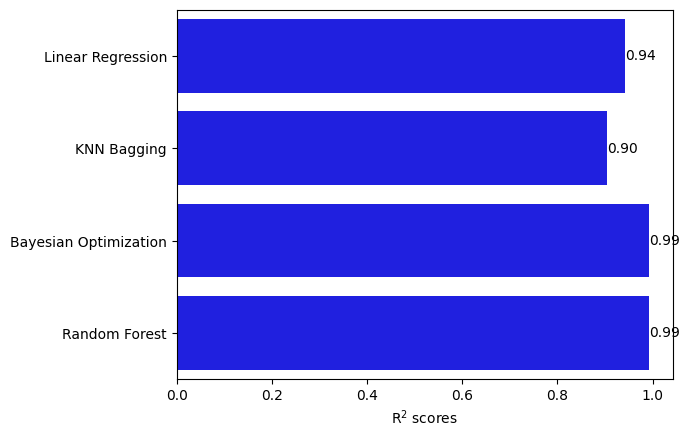

In [59]:
scores = [reg_r2, bag_r2, bay_r2, rf_r2]
ax = sns.barplot(x=scores, y=models, orient='h', color='blue')
plt.xlabel('R$^2$ scores')
bars = ax.containers[0]
ax.bar_label(bars, labels=[f'{value:.2f}' for value in bars.datavalues])

plt.show()